# Анализ дифференциальной экспрессии генов методами машинного обучения

## Агеев Андрей

Задание:

Проведите анализ данных экспресии генов (https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE26728) :

1. Информация о каком количестве генов есть в исследовании? 

2. Есть ли в данных дубликаты по генам? Что еще вы можете сказать о данных?

3. Посчитайте средние значения экспресии каждого из генов в контроле, low_dose и high_dose. Если обнаружите дубликаты, усредните и их.

4. Воспользуйтесь деревом решений высотой 2 и постройте классификаторы control vs low_dose, control vs high_dose. Какие гены оказались лучшими признаками для разделения? Совпали ли признаки в деревьях?

Данные образцов представляют собой RNA. Данные были получены с использованием микрочипов. Отсканированные изображения анализировали с помощью программного обеспечения Feature Extraction 9.5 (Agilent) с использованием параметров по умолчанию (протокол GE1-v5_95 и Grid: 014868_D_20070207). Все последующие анализы данных проводились в R (www.r-project.org) с использованием пакетов Bioconductor (www.bioconductor.org). Необработанные данные (медиана интенсивности пикселей) были импортированы в R с помощью функции read.maimages из пакета limma со следующей функцией веса (назначая вес 1 или 0 для каждого пятна): myfunw <-function (x) {okType < -x $ ControlType == 0 okFoundGreen <-x $ gIsFound == 1 okPos = x $ gIsPosAndSignif == 1 okWellAbove <- x $ gIsWellAboveBG == 1 as.numeric (okType & okFoundGreen & okPos & okWell) с весом 1 на 15 из 18 микрочипов или с весом 1 на все 6 микрочипов по меньшей мере из одной экспериментальной группы. Затем данные были сохранены в объекте ExpressionSet и нормализованы методом квантилей с использованием функции normalize.quantiles из библиотеки preprocessCore. Реплицированные зонды в массиве (идентичные ProbeName) были разрешены путем взятия среднего нормализованного сигнала каждого набора реплицированных зондов. Результирующая матрица имеет 22514 строк, каждая из которых соответствует уникальному ProbeName (предоставляется как матрица данных).

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import pylab
import scipy.stats as stats
from matplotlib import pyplot as plt

from sklearn import tree 
import pydotplus 
from IPython.display import Image 
import graphviz

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score



Поработаем с аннотацией, чтобы понять какие гены соответствуют пробам.

In [2]:
annotation = pd.read_table("GSE26728_family.soft")

In [3]:
annotation = annotation.iloc[0:41174]

In [4]:
annotation

,ID,SPOT_ID,CONTROL_TYPE,REFSEQ,GB_ACC,GENE,GENE_SYMBOL,GENE_NAME,UNIGENE_ID,ENSEMBL_ID,TIGR_ID,ACCESSION_STRING,CHROMOSOMAL_LOCATION,CYTOBAND,DESCRIPTION,GO_ID,SEQUENCE
0,A_51_P100021,A_51_P100021,False,NaN,AY454345,16656.0,Hivep3,human immunodeficiency virus type I enhancer b...,Mm.302758,NaN,NaN,gb|AY454345|tc|TC1584815|nap|NAP057482-1,chr4:119807944-119808005,mm|4qD2.1,Mus musculus clone pZAS3 328-2275 zinc finger ...,GO:0003676(nucleic acid binding)|GO:0003677(DN...,CATGGCTGGATTAACGTATGTGTGTGGTATATAGATACACAGAGAG...
1,A_51_P100034,A_51_P100034,False,NM_027162,NM_027162,69674.0,Mif4gd,MIF4G domain containing,Mm.390387,NaN,NaN,ref|NM_027162|ref|NM_001243586|ref|NM_00124358...,chr11:115469328-115469269,mm|11qE2,"Mus musculus MIF4G domain containing (Mif4gd),...",GO:0005488(binding)|GO:0005575(cellular_compon...,GAGACTTTTGTGGAGGAAGCCTGTTTCCTCCAGTCATGAGTGACTG...
2,A_51_P100052,A_51_P100052,False,NM_198863,NM_198863,245450.0,Slitrk2,"SLIT and NTRK-like family, member 2",Mm.336081,ENSMUST00000036043,NaN,ref|NM_198863|ref|NM_001161431|ens|ENSMUST0000...,chrX:63908145-63908204,mm|XqA7.1,"Mus musculus SLIT and NTRK-like family, member...",GO:0003674(molecular_function)|GO:0007409(axon...,CTAAATGTGAATTGCCAAGAAAGGAAGTTCACTAACATCTCTGACC...
3,A_51_P100063,A_51_P100063,False,NM_010727,NM_010727,16924.0,Lnx1,ligand of numb-protein X 1,Mm.440403,NaN,NaN,ref|NM_010727|ref|NM_001159577|ref|NM_00115957...,chr5:74993810-74993386,mm|5qC3.3,Mus musculus ligand of numb-protein X 1 (Lnx1)...,GO:0004842(ubiquitin-protein ligase activity)|...,GAAGAATCAGATGTGGTGACATTCTTCTCGCTGTCAACGGTAGAAG...
4,A_51_P100084,A_51_P100084,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nap|NAP091803-1,unmapped,NaN,NaN,NaN,AAGTCATCTCTCATGCCTATCAGAATACTCTGCCTCTAAGCCCAAA...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41169,A_52_P99848,A_52_P99848,FALSE,NM_008840,NM_008840,18707.0,Pik3cd,phosphatidylinositol 3-kinase catalytic delta ...,Mm.229108,NaN,NaN,ref|NM_008840|ref|NM_001164051|ref|NM_00116404...,chr4:149023341-149023282,mm|4qE2,Mus musculus phosphatidylinositol 3-kinase cat...,GO:0000166(nucleotide binding)|GO:0001782(B ce...,TGTGCAACCTTGACCCAACAGGTAAAGACAGGTGAAAAGAAATAAA...
41170,A_52_P99885,A_52_P99885,FALSE,NaN,AK044940,100039681.0,Zcwpw2,"zinc finger, CW type with PWWP domain 2",Mm.460261,NaN,NaN,gb|AK044940|tc|TC1611228|riken|B130014L17|nap|...,chr9:117922581-117922522,mm|9qF3,Mus musculus 9.5 days embryo parthenogenote cD...,GO:0003674(molecular_function)|GO:0005575(cell...,TCTTGTTCTCTATGAAGACCGTAAGGAATCAGTCATAAGAGAGGTG...
41171,A_52_P99888,A_52_P99888,FALSE,NM_023158,NM_023158,66102.0,Cxcl16,chemokine (C-X-C motif) ligand 16,Mm.425692,ENSMUST00000126391,NaN,ref|NM_023158|ens|ENSMUST00000126391|ens|ENSMU...,chr11:70267839-70267780,mm|11qB3,Mus musculus chemokine (C-X-C motif) ligand 16...,GO:0005041(low-density lipoprotein receptor ac...,TGTAAAGTTCTAGGTTCAACCCTCCCACTACCAGATCAATTTTAAA...
41172,A_52_P99948,A_52_P99948,FALSE,NaN,AK040970,212514.0,Spice1,spindle and centriole associated protein 1,Mm.483587,NaN,NaN,gb|AK040970|tc|TC1591034|riken|A530052K23,chr16:44384310-44384369,mm|16qB4,"Mus musculus adult male aorta and vein cDNA, R...",GO:0003674(molecular_function)|GO:0005634(nucl...,AAAGAAACCCTATTTAGTTTTATCAAATTCAAAAATTAAACTTTAC...


In [5]:
len(annotation["ID"].unique().tolist())

41174

Результирующая матрица имеет 22514 строк, каждая из которых соответствует уникальному ProbeName. Получим эти названия и выберем в аннотации только интересующие нас пробы.

In [6]:
probe_name = []
for i in range(75, 76):
    file = "GSE26728_family.xml/" + "GSM6580" + str(i) + "-tbl-1.txt"
    with open(file) as f:
        for line in f:
            data = line.split("\t")
            probe_name.append(data[0])

In [7]:
a = annotation.loc[annotation.ID.isin(probe_name)]


Получим количество уникальных генов.

In [8]:
len(a["GENE_SYMBOL"].unique().tolist())

13322

Одному гену может соответсововать несколько проб.

In [9]:
a["GENE_SYMBOL"].value_counts()

Usp15      7
Cflar      7
Ube2i      7
Csnk1a1    6
Sbf2       6
          ..
Zc3h12c    1
Glmn       1
Mfsd10     1
Sar1b      1
Sfrp1      1
Name: GENE_SYMBOL, Length: 13321, dtype: int64

В данных есть один пропуск, который мы уберем

In [10]:
import math
probes = []
for gene in a["GENE_SYMBOL"].unique().tolist():
    if gene is np.nan:
        continue
    probes.append((gene, a.loc[a.GENE_SYMBOL==gene].ID.tolist()))


Получим соответствие генов пробам.

In [11]:
probes

[('Mif4gd', ['A_51_P100034']),
 ('Lnx1', ['A_51_P100063']),
 ('2610002J23Rik', ['A_51_P100099', 'A_52_P328116']),
 ('Rpf1', ['A_51_P100155', 'A_52_P517001', 'A_52_P517006']),
 ('Mns1', ['A_51_P100174']),
 ('Med14', ['A_51_P100181', 'A_51_P281134', 'A_52_P406371']),
 ('Ipo5', ['A_51_P100227', 'A_52_P235569']),
 ('Ube2m', ['A_51_P100246', 'A_52_P665386']),
 ('Srf', ['A_51_P100289']),
 ('Tap1', ['A_51_P100327']),
 ('D19Ertd386e', ['A_51_P100470', 'A_52_P486482']),
 ('Map3k3', ['A_51_P100565', 'A_51_P100573']),
 ('Apon', ['A_51_P100625']),
 ('Snw1', ['A_51_P100787', 'A_52_P662695']),
 ('Prdx3', ['A_51_P100828']),
 ('Fam26f', ['A_51_P100852']),
 ('Fn1', ['A_51_P100856', 'A_52_P11817', 'A_52_P299974']),
 ('Atp5j', ['A_51_P100866']),
 ('Gucy2c', ['A_51_P100991']),
 ('Serpinb3c', ['A_51_P100997']),
 ('1810031K17Rik', ['A_51_P101075']),
 ('Zfp397', ['A_51_P101086', 'A_52_P260840']),
 ('Samd14', ['A_51_P101137']),
 ('Psme1', ['A_51_P101196']),
 ('Gmeb2', ['A_51_P101228', 'A_52_P570738']),
 ('Coa

In [12]:
len(probes)

13321

Таким образом, в данные есть 13321 ген

Посчитаем средние для каждого условия, усредняя по дубликатам генов.

In [13]:
genes_control = []
genes_high = []
genes_low = []
control = [75, 76, 77, 78,79, 80]
low = [81, 82, 83, 84, 85, 86]
high = [87, 88, 89, 90, 91,92]

for cond in range(0,3):
    rna_data = [] 
    if cond == 0:
        index_file = control
    elif cond == 1:
        index_file = low
    elif cond == 2:
        index_file = high        
    for i in index_file:
        file = "GSE26728_family.xml/" + "GSM6580" + str(i) + "-tbl-1.txt"
        with open(file) as f:
            for line in f:
                data = line.split("\t")
                rna_data.append((data[0],float(data[1].rstrip())))                    
    result = []
    for probe in probes:
        mean_c = []
        for p_id in probe[1]:
            for rna in rna_data:
                rna_name = rna[0]
                rna_value = rna[1]
                if(rna_name == p_id):
                    mean_c.append(rna_value)
        result.append((probe[0], np.mean(mean_c)))       
    if cond == 0:
        genes_control = result
    elif cond == 1:
        genes_low = result
    elif cond == 2:
        genes_high = result




Выведем средние для control, low и high

In [14]:
genes_control

[('Mif4gd', 12.365),
 ('Lnx1', 6.108),
 ('2610002J23Rik', 6.883916666666665),
 ('Rpf1', 10.177222222222222),
 ('Mns1', 6.219),
 ('Med14', 7.304888888888889),
 ('Ipo5', 8.505916666666666),
 ('Ube2m', 9.726083333333333),
 ('Srf', 8.424666666666667),
 ('Tap1', 7.324166666666667),
 ('D19Ertd386e', 6.78025),
 ('Map3k3', 7.603166666666667),
 ('Apon', 13.662166666666666),
 ('Snw1', 9.510333333333334),
 ('Prdx3', 11.4095),
 ('Fam26f', 6.0385),
 ('Fn1', 10.675666666666666),
 ('Atp5j', 14.313333333333334),
 ('Gucy2c', 6.9465),
 ('Serpinb3c', 6.342666666666666),
 ('1810031K17Rik', 13.196333333333333),
 ('Zfp397', 7.0064166666666665),
 ('Samd14', 5.994),
 ('Psme1', 13.160499999999999),
 ('Gmeb2', 7.083500000000001),
 ('Coasy', 13.432666666666668),
 ('Prmt3', 6.435791666666667),
 ('Pls1', 7.828),
 ('St6gal1', 9.276833333333334),
 ('Slit1', 6.432166666666667),
 ('Vac14', 7.13175),
 ('Dsp', 8.734055555555555),
 ('Trfr2', 14.703666666666665),
 ('Hif3a', 6.630333333333333),
 ('Hgfac', 12.50533333333333

In [15]:
genes_low

[('Mif4gd', 12.1485),
 ('Lnx1', 6.133333333333333),
 ('2610002J23Rik', 6.975083333333334),
 ('Rpf1', 10.098666666666666),
 ('Mns1', 6.077666666666666),
 ('Med14', 7.29),
 ('Ipo5', 8.513333333333334),
 ('Ube2m', 9.542583333333333),
 ('Srf', 8.295499999999999),
 ('Tap1', 7.314999999999999),
 ('D19Ertd386e', 6.692666666666667),
 ('Map3k3', 7.509333333333333),
 ('Apon', 13.795166666666667),
 ('Snw1', 9.413833333333333),
 ('Prdx3', 11.333333333333334),
 ('Fam26f', 6.155333333333334),
 ('Fn1', 10.621777777777778),
 ('Atp5j', 14.344666666666667),
 ('Gucy2c', 6.876),
 ('Serpinb3c', 6.263166666666667),
 ('1810031K17Rik', 12.8545),
 ('Zfp397', 7.086083333333334),
 ('Samd14', 6.027),
 ('Psme1', 13.049000000000001),
 ('Gmeb2', 7.127416666666668),
 ('Coasy', 13.470999999999998),
 ('Prmt3', 6.458375),
 ('Pls1', 7.8486666666666665),
 ('St6gal1', 9.384333333333334),
 ('Slit1', 6.398833333333333),
 ('Vac14', 7.270416666666666),
 ('Dsp', 8.823277777777777),
 ('Trfr2', 14.739333333333335),
 ('Hif3a', 6.6

In [16]:
genes_high

[('Mif4gd', 12.182333333333332),
 ('Lnx1', 6.648),
 ('2610002J23Rik', 6.864249999999999),
 ('Rpf1', 10.004944444444444),
 ('Mns1', 6.1995000000000005),
 ('Med14', 7.2635555555555555),
 ('Ipo5', 8.50675),
 ('Ube2m', 9.472416666666666),
 ('Srf', 8.351833333333333),
 ('Tap1', 7.608333333333334),
 ('D19Ertd386e', 6.76175),
 ('Map3k3', 7.548749999999999),
 ('Apon', 13.950666666666665),
 ('Snw1', 9.480666666666668),
 ('Prdx3', 11.234833333333334),
 ('Fam26f', 6.546166666666667),
 ('Fn1', 10.791611111111113),
 ('Atp5j', 14.359833333333333),
 ('Gucy2c', 7.1915000000000004),
 ('Serpinb3c', 6.354166666666667),
 ('1810031K17Rik', 13.042166666666667),
 ('Zfp397', 6.9935833333333335),
 ('Samd14', 6.0565),
 ('Psme1', 13.14),
 ('Gmeb2', 7.084583333333332),
 ('Coasy', 13.439833333333333),
 ('Prmt3', 6.383166666666667),
 ('Pls1', 8.554166666666665),
 ('St6gal1', 9.450333333333333),
 ('Slit1', 6.442666666666667),
 ('Vac14', 7.160583333333332),
 ('Dsp', 8.681111111111113),
 ('Trfr2', 14.756666666666666),

Получим для каждого образца результаты по генам, усреднив пробы

In [17]:
newDF = pd.DataFrame() 
for i in range(75, 93):
    genes = []
    file = "GSE26728_family.xml/" +"GSM6580" + str(i) + "-tbl-1.txt"
    print(file)
    with open(file) as f:
        for line in f:
            data = line.split("\t")
            genes.append((data[0],float(data[1].rstrip())))
    result_one = []
    gene_one = []
    for probe in probes:
        mean_c = []
        for p in probe[1]:
            for gene in genes:
                if(gene[0] == p):
                    mean_c.append(gene[1])
        result_one.append(np.mean(mean_c))
        gene_one.append(probe[0])
    c_d = pd.DataFrame([result_one], columns = gene_one)
    newDF = newDF.append(c_d, ignore_index = True)



GSE26728_family.xml/GSM658075-tbl-1.txt
GSE26728_family.xml/GSM658076-tbl-1.txt
GSE26728_family.xml/GSM658077-tbl-1.txt
GSE26728_family.xml/GSM658078-tbl-1.txt
GSE26728_family.xml/GSM658079-tbl-1.txt
GSE26728_family.xml/GSM658080-tbl-1.txt
GSE26728_family.xml/GSM658081-tbl-1.txt
GSE26728_family.xml/GSM658082-tbl-1.txt
GSE26728_family.xml/GSM658083-tbl-1.txt
GSE26728_family.xml/GSM658084-tbl-1.txt
GSE26728_family.xml/GSM658085-tbl-1.txt
GSE26728_family.xml/GSM658086-tbl-1.txt
GSE26728_family.xml/GSM658087-tbl-1.txt
GSE26728_family.xml/GSM658088-tbl-1.txt
GSE26728_family.xml/GSM658089-tbl-1.txt
GSE26728_family.xml/GSM658090-tbl-1.txt
GSE26728_family.xml/GSM658091-tbl-1.txt
GSE26728_family.xml/GSM658092-tbl-1.txt


In [18]:

newDF

,Mif4gd,Lnx1,2610002J23Rik,Rpf1,Mns1,Med14,Ipo5,Ube2m,Srf,Tap1,...,Gm4371,D430019H16Rik,Aasdh,Sowahc,Btrc,D130084N16Rik,Ippk,9130230N09Rik,A630031M23Rik,Pik3cd
0,12.630,5.828,6.8980,10.292333,6.632,7.376667,8.5230,9.8860,8.455,7.155,...,6.496,7.221,8.407,7.432,6.766,6.116,7.974,7.651,8.821,6.951
1,11.899,6.598,7.0020,10.053667,6.089,7.256667,8.5140,9.6695,8.218,7.349,...,7.731,6.812,8.574,7.476,6.765,6.456,7.802,7.246,8.740,7.187
2,12.393,5.984,6.6235,10.099000,6.012,7.215667,8.5120,9.9415,8.639,7.260,...,6.657,7.295,8.707,7.279,6.629,6.235,7.721,7.240,8.799,7.154
3,12.539,5.986,7.1005,10.515667,6.190,7.334667,8.4910,9.8580,8.550,6.955,...,6.389,7.210,8.696,7.513,6.840,6.434,8.294,7.352,8.063,6.452
4,12.368,6.089,6.8765,10.118000,6.260,7.366667,8.4780,9.1720,8.273,7.379,...,7.384,7.168,8.647,7.441,6.742,6.103,8.085,7.582,8.553,7.582
5,12.361,6.163,6.8030,9.984667,6.131,7.279000,8.5175,9.8295,8.413,7.847,...,6.834,7.012,8.615,7.417,6.632,6.318,7.904,6.988,8.428,6.585
6,12.332,6.384,6.6715,10.056667,5.993,7.275333,8.4675,9.4720,8.399,7.752,...,7.513,7.486,8.479,7.787,6.474,6.314,7.931,6.974,7.464,7.758
7,12.148,6.410,7.0625,10.029333,6.274,7.391333,8.4835,9.3575,8.254,7.066,...,6.361,7.024,8.719,7.587,6.803,6.156,7.697,7.362,8.489,6.601
8,12.032,5.984,7.0335,10.218333,6.002,7.120667,8.5085,9.6660,8.398,7.097,...,7.299,7.173,8.437,7.440,6.634,6.105,7.592,7.042,8.437,6.838
9,11.955,6.158,7.0050,10.086333,6.011,7.315667,8.3745,9.7705,8.457,7.221,...,6.716,6.797,8.376,7.482,6.985,6.342,7.688,7.047,8.243,6.869


In [19]:
data = newDF

Строим деревья. Для этого добавим в данные метки образцов: 0 - control, 1 - low, 2 - high. Деревья будут высоты 2. 

In [20]:
data["label"] = [0,0,0,0,0,0,1,1,1,1,1,1,2,2,2,2,2,2]

In [21]:
data

,Mif4gd,Lnx1,2610002J23Rik,Rpf1,Mns1,Med14,Ipo5,Ube2m,Srf,Tap1,...,D430019H16Rik,Aasdh,Sowahc,Btrc,D130084N16Rik,Ippk,9130230N09Rik,A630031M23Rik,Pik3cd,label
0,12.630,5.828,6.8980,10.292333,6.632,7.376667,8.5230,9.8860,8.455,7.155,...,7.221,8.407,7.432,6.766,6.116,7.974,7.651,8.821,6.951,0
1,11.899,6.598,7.0020,10.053667,6.089,7.256667,8.5140,9.6695,8.218,7.349,...,6.812,8.574,7.476,6.765,6.456,7.802,7.246,8.740,7.187,0
2,12.393,5.984,6.6235,10.099000,6.012,7.215667,8.5120,9.9415,8.639,7.260,...,7.295,8.707,7.279,6.629,6.235,7.721,7.240,8.799,7.154,0
3,12.539,5.986,7.1005,10.515667,6.190,7.334667,8.4910,9.8580,8.550,6.955,...,7.210,8.696,7.513,6.840,6.434,8.294,7.352,8.063,6.452,0
4,12.368,6.089,6.8765,10.118000,6.260,7.366667,8.4780,9.1720,8.273,7.379,...,7.168,8.647,7.441,6.742,6.103,8.085,7.582,8.553,7.582,0
5,12.361,6.163,6.8030,9.984667,6.131,7.279000,8.5175,9.8295,8.413,7.847,...,7.012,8.615,7.417,6.632,6.318,7.904,6.988,8.428,6.585,0
6,12.332,6.384,6.6715,10.056667,5.993,7.275333,8.4675,9.4720,8.399,7.752,...,7.486,8.479,7.787,6.474,6.314,7.931,6.974,7.464,7.758,1
7,12.148,6.410,7.0625,10.029333,6.274,7.391333,8.4835,9.3575,8.254,7.066,...,7.024,8.719,7.587,6.803,6.156,7.697,7.362,8.489,6.601,1
8,12.032,5.984,7.0335,10.218333,6.002,7.120667,8.5085,9.6660,8.398,7.097,...,7.173,8.437,7.440,6.634,6.105,7.592,7.042,8.437,6.838,1
9,11.955,6.158,7.0050,10.086333,6.011,7.315667,8.3745,9.7705,8.457,7.221,...,6.797,8.376,7.482,6.985,6.342,7.688,7.047,8.243,6.869,1


In [22]:
control = data.iloc[0:6]
low = data.iloc[6:12]
high = data.iloc[12:19]

In [23]:
check = pd.concat([control, low])


In [24]:
check

,Mif4gd,Lnx1,2610002J23Rik,Rpf1,Mns1,Med14,Ipo5,Ube2m,Srf,Tap1,...,D430019H16Rik,Aasdh,Sowahc,Btrc,D130084N16Rik,Ippk,9130230N09Rik,A630031M23Rik,Pik3cd,label
0,12.630,5.828,6.8980,10.292333,6.632,7.376667,8.5230,9.8860,8.455,7.155,...,7.221,8.407,7.432,6.766,6.116,7.974,7.651,8.821,6.951,0
1,11.899,6.598,7.0020,10.053667,6.089,7.256667,8.5140,9.6695,8.218,7.349,...,6.812,8.574,7.476,6.765,6.456,7.802,7.246,8.740,7.187,0
2,12.393,5.984,6.6235,10.099000,6.012,7.215667,8.5120,9.9415,8.639,7.260,...,7.295,8.707,7.279,6.629,6.235,7.721,7.240,8.799,7.154,0
3,12.539,5.986,7.1005,10.515667,6.190,7.334667,8.4910,9.8580,8.550,6.955,...,7.210,8.696,7.513,6.840,6.434,8.294,7.352,8.063,6.452,0
4,12.368,6.089,6.8765,10.118000,6.260,7.366667,8.4780,9.1720,8.273,7.379,...,7.168,8.647,7.441,6.742,6.103,8.085,7.582,8.553,7.582,0
5,12.361,6.163,6.8030,9.984667,6.131,7.279000,8.5175,9.8295,8.413,7.847,...,7.012,8.615,7.417,6.632,6.318,7.904,6.988,8.428,6.585,0
6,12.332,6.384,6.6715,10.056667,5.993,7.275333,8.4675,9.4720,8.399,7.752,...,7.486,8.479,7.787,6.474,6.314,7.931,6.974,7.464,7.758,1
7,12.148,6.410,7.0625,10.029333,6.274,7.391333,8.4835,9.3575,8.254,7.066,...,7.024,8.719,7.587,6.803,6.156,7.697,7.362,8.489,6.601,1
8,12.032,5.984,7.0335,10.218333,6.002,7.120667,8.5085,9.6660,8.398,7.097,...,7.173,8.437,7.440,6.634,6.105,7.592,7.042,8.437,6.838,1
9,11.955,6.158,7.0050,10.086333,6.011,7.315667,8.3745,9.7705,8.457,7.221,...,6.797,8.376,7.482,6.985,6.342,7.688,7.047,8.243,6.869,1


In [25]:
X_train, X_holdout, y_train, y_holdout = train_test_split(check.iloc[:,0:13321], check["label"], test_size=0.33,
random_state=2)



In [26]:
clf = tree.DecisionTreeClassifier(max_depth=2,random_state=2, criterion = 'entropy',max_features = 1)

clf_train = clf.fit(X_train, y_train)

In [27]:
print(tree.export_graphviz(clf_train, None))
dot_data = tree.export_graphviz(clf_train, out_file=None, feature_names=check.columns[0:13321], 
                                class_names=['Control', 'Low'], rounded=True, filled=True) #Gini decides which attribute/feature should be placed at the root node, which features will act as internal nodes or leaf nodes




digraph Tree {
node [shape=box] ;
0 [label="X[10568] <= 6.093\nentropy = 1.0\nsamples = 8\nvalue = [4, 4]"] ;
1 [label="entropy = 0.0\nsamples = 3\nvalue = [3, 0]"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label="X[9670] <= 7.903\nentropy = 0.722\nsamples = 5\nvalue = [1, 4]"] ;
0 -> 2 [labeldistance=2.5, labelangle=-45, headlabel="False"] ;
3 [label="entropy = 0.0\nsamples = 4\nvalue = [0, 4]"] ;
2 -> 3 ;
4 [label="entropy = 0.0\nsamples = 1\nvalue = [1, 0]"] ;
2 -> 4 ;
}


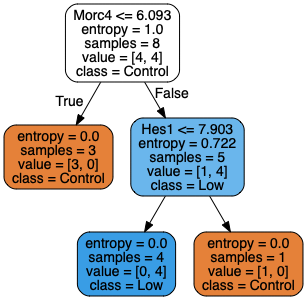

In [28]:
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

Посмотрим точность на тренировочной выборке.

In [29]:
tree_pred = clf_train.predict(X_train)
accuracy_score(y_train, tree_pred)

1.0

Точность на тестовой

In [30]:
tree_pred = clf_train.predict(X_holdout)
accuracy_score(y_holdout, tree_pred)

0.75

Посмотрим,как влияют гены, по которым мы рассматриваем разбиение

In [31]:
importances = clf.feature_importances_

X = check.iloc[:,0:13321].values
indices = np.argsort(importances)[::-1]

print("Feature ranking:")

for f in range(2):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))



Feature ranking:
1. feature 10568 (0.548795)
2. feature 9670 (0.451205)


Сделаем тоже самое с control vs high

In [32]:
check = pd.concat([control, high])

In [33]:
check

,Mif4gd,Lnx1,2610002J23Rik,Rpf1,Mns1,Med14,Ipo5,Ube2m,Srf,Tap1,...,D430019H16Rik,Aasdh,Sowahc,Btrc,D130084N16Rik,Ippk,9130230N09Rik,A630031M23Rik,Pik3cd,label
0,12.630,5.828,6.8980,10.292333,6.632,7.376667,8.5230,9.8860,8.455,7.155,...,7.221,8.407,7.432,6.766,6.116,7.974,7.651,8.821,6.951,0
1,11.899,6.598,7.0020,10.053667,6.089,7.256667,8.5140,9.6695,8.218,7.349,...,6.812,8.574,7.476,6.765,6.456,7.802,7.246,8.740,7.187,0
2,12.393,5.984,6.6235,10.099000,6.012,7.215667,8.5120,9.9415,8.639,7.260,...,7.295,8.707,7.279,6.629,6.235,7.721,7.240,8.799,7.154,0
3,12.539,5.986,7.1005,10.515667,6.190,7.334667,8.4910,9.8580,8.550,6.955,...,7.210,8.696,7.513,6.840,6.434,8.294,7.352,8.063,6.452,0
4,12.368,6.089,6.8765,10.118000,6.260,7.366667,8.4780,9.1720,8.273,7.379,...,7.168,8.647,7.441,6.742,6.103,8.085,7.582,8.553,7.582,0
5,12.361,6.163,6.8030,9.984667,6.131,7.279000,8.5175,9.8295,8.413,7.847,...,7.012,8.615,7.417,6.632,6.318,7.904,6.988,8.428,6.585,0
12,12.107,6.441,6.7815,10.209333,6.375,7.294000,8.4960,9.5720,8.375,7.700,...,7.364,8.605,7.399,6.885,6.123,7.556,7.058,8.658,6.741,2
13,12.529,7.814,6.6930,9.813333,6.087,7.222000,8.5210,9.3120,8.178,7.546,...,6.536,8.136,7.917,6.890,6.149,8.032,7.130,7.246,8.453,2
14,11.838,6.107,7.2105,10.154667,6.152,7.160333,8.4025,9.4580,8.192,7.513,...,7.272,8.776,7.642,7.067,6.152,7.539,6.743,8.586,6.870,2
15,12.054,7.017,6.8690,9.951000,6.202,7.292000,8.5660,9.5385,8.323,7.219,...,7.221,8.615,7.552,6.581,6.395,7.766,7.064,7.994,6.755,2


In [34]:
X_train, X_holdout, y_train, y_holdout = train_test_split(check.iloc[:,0:13321],check["label"], test_size=0.33,
random_state=2)

clf = tree.DecisionTreeClassifier(max_depth=2,random_state=2, criterion = 'entropy',max_features = 1)

clf_train = clf.fit(X_train, y_train)

In [35]:
print(tree.export_graphviz(clf_train, None))
dot_data = tree.export_graphviz(clf_train, out_file=None, feature_names=check.columns[0:13321], 
                                class_names=['Control', 'High'], rounded=True, filled=True) #Gini decides which attribute/feature should be placed at the root node, which features will act as internal nodes or leaf nodes




digraph Tree {
node [shape=box] ;
0 [label="X[10568] <= 5.977\nentropy = 1.0\nsamples = 8\nvalue = [4, 4]"] ;
1 [label="entropy = 0.0\nsamples = 2\nvalue = [2, 0]"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label="X[9670] <= 7.951\nentropy = 0.918\nsamples = 6\nvalue = [2, 4]"] ;
0 -> 2 [labeldistance=2.5, labelangle=-45, headlabel="False"] ;
3 [label="entropy = 1.0\nsamples = 4\nvalue = [2, 2]"] ;
2 -> 3 ;
4 [label="entropy = 0.0\nsamples = 2\nvalue = [0, 2]"] ;
2 -> 4 ;
}


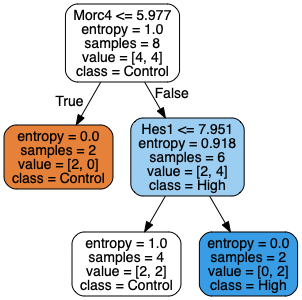

In [36]:
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [37]:
tree_pred = clf_train.predict(X_train)
accuracy_score(y_train, tree_pred)

0.75

In [38]:
tree_pred = clf_train.predict(X_holdout)
accuracy_score(y_holdout, tree_pred)

0.5

In [39]:
importances = clf.feature_importances_

X = check.iloc[:,0:13321].values
indices = np.argsort(importances)[::-1]

print("Feature ranking:")

for f in range(2):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))



Feature ranking:
1. feature 10568 (0.622556)
2. feature 9670 (0.377444)


Видно, что для данного разбиения по этим генам влияние похожее.

## Выводы

Следует отметить, что в данных очень немного образцов и очень много признаков.

Кроме того, существует проблема выбора признаков, и для выбора генов оказывающих большее влияние следует провести больше исследований и тестов.

Также можно попробовать использовать ансабли деревьев решений(RandomForest).
